In [5]:
import numpy as np
from numpy import zeros, eye
from scipy.stats import multivariate_normal as MVN

# Question 1

In [10]:
def is_sampler(N, d):
    # Proposal distribution
    q = MVN(zeros(d), 2*eye(d))
    # Target distribution
    p = MVN(zeros(d), eye(d))
    # Samples N particles
    x = q.rvs(N)
    # Importance weights
    W = p.pdf(x) / q.pdf(x)
    # normalize
    w = W / W.sum()
    return W, w

In [11]:
is_sampler(10, 1000)

/var/folders/hy/57_f4xcx08b0ls2_nwwfjscr0000gn/T/ipykernel_13512/2485241773.py:9: RuntimeWarning: invalid value encountered in true_divide
  W = p.pdf(x) / q.pdf(x)


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]))

# Question 2

In [18]:
def is_sampler_logscale(N, d):
    # Proposal distribution
    q = MVN(zeros(d), 2*eye(d))
    # Target distribution
    p = MVN(zeros(d), eye(d))
    # Samples N particles
    x = q.rvs(N)
    # Importance weights
    W = np.exp(p.logpdf(x) - q.logpdf(x))
    # Normalize
    w = W / W.sum()
    return W, w, W.sum()

In [19]:
is_sampler_logscale(10, 1000)

(array([1.37999266e-61, 1.58182312e-67, 6.42818864e-47, 1.17983694e-68,
        8.13392387e-64, 5.09360791e-55, 2.58952251e-73, 4.63325744e-66,
        3.78954002e-73, 8.97125209e-74]),
 array([2.14678307e-15, 2.46076025e-21, 9.99999992e-01, 1.83541118e-22,
        1.26535238e-17, 7.92386184e-09, 4.02838596e-27, 7.20771848e-20,
        5.89519101e-27, 1.39561119e-27]),
 6.428188689087494e-47)

# Question 4

In [16]:
def is_sampler_logscale_transform(N, d):
    # Proposal distribution
    q = MVN(zeros(d), 2*eye(d))
    # Target distribution
    p = MVN(zeros(d), eye(d))
    # Samples N particles
    x = q.rvs(N)
    # Log Importance weights
    logW = p.logpdf(x) - q.logpdf(x)
    m = max(logW)
    t = logW - m
    numerator = np.exp(t)
    denominator = np.exp(t).sum()
    final_weights = numerator / denominator
    return final_weights, numerator, denominator

In [17]:
is_sampler_logscale_transform(10, 1000)

(array([1.02517326e-17, 1.09705740e-13, 1.43243122e-08, 9.96345354e-01,
        3.02926073e-25, 7.83398391e-19, 3.97036048e-21, 3.65463216e-03,
        1.36669921e-20, 7.27423701e-13]),
 array([1.02893365e-17, 1.10108146e-13, 1.43768545e-08, 1.00000000e+00,
        3.04037222e-25, 7.86271937e-19, 3.98492397e-21, 3.66803754e-03,
        1.37171233e-20, 7.30091928e-13]),
 1.003668051915046)

# Gaussian Model for Continuous States

In [57]:
from scipy.stats import norm as ndist
from numpy.random import normal
import matplotlib.pyplot as plt
from numpy.random import choice

In [29]:
ϕ = 0.98
σ = 0.16
β = 0.7
θ = np.array([ϕ, σ, β])
T = 500

In [44]:
def rstate(θ, xprev):
    ϕ, σ, β = θ
    return normal(loc=ϕ*xprev, scale=σ**2)

def dstate(θ, xprev, xcurr):
    ϕ, σ, β = θ
    return ndist(loc=ϕ*xprev, scale=σ**2).pdf(xcurr)

def robs(θ, xcurr):
    ϕ, σ, β = θ
    return normal(loc=0.0, scale=(β**2)*np.exp(xcurr))

def dobs(θ, xcurr, ycurr):
    ϕ, σ, β = θ
    return ndist(loc=0.0, scale=(β**2)*np.exp(xcurr)).pdf(ycurr)

def ldobs(θ, xcurr, ycurr):
    ϕ, σ, β = θ
    return ndist(loc=0.0, scale=(β**2)*np.exp(xcurr)).logpdf(ycurr)

In [45]:
μ = lambda N: normal(loc=0.0, scale=σ**2, size=N)

In [77]:
x = μ(1)
x_values = [x]
y_values = []
for t in range(T):
    x = rstate(θ, x)
    y = robs(θ, x)
    x_values.append(x)
    y_values.append(y)

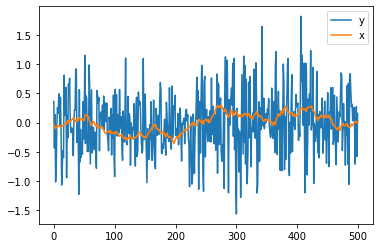

In [78]:
fig, ax = plt.subplots()
ax.plot(y_values, label='y')
ax.plot(x_values, label='x')
ax.legend()
plt.show()

In [84]:
def process_N_particles(x, N, T):
    ### x here is a list of N particles
    x_values = zeros((T+1, N))
    y_values = zeros((T, N))
    x_values[0, :] = x
    for t in range(T):
        x = rstate(θ, x)
        y = robs(θ, x)
        x_values[t+1, :] = x
        y_values[t, :] = y
    if N > 1:
        return x_values, y_values
    else:
        return x_values.flatten(), y_values.flatten()

In [90]:
N = 1
x_start = μ(N)

In [92]:
x_values, y_values = process_N_particles(x_start, 1, T)

In [138]:
def bfp(ys, N, T):
    # Sample from prior
    x = μ(N)
    x_before = x
    x_after  = x
    weights = np.ones(N)
    for t in range(T):
        # sample
        x = rstate(θ, x)
        x_before = np.vstack((x_before, x))
        # compute weights
        logW = ldobs(θ, x, ys[t])
        m = max(logW)
        t = logW - m
        w = np.exp(t) / np.exp(t).sum()
        weights = np.vstack((weights, w))
        # resample 
        ix = choice(np.arange(N), size=N, replace=True, p=w)
        x = x[ix]
        x_after = np.vstack((x_after, x))
    return weights, x_before, x_after

In [141]:
N = 100
T = 500
weights, x_before, x_after = bfp(y_values, N, T)

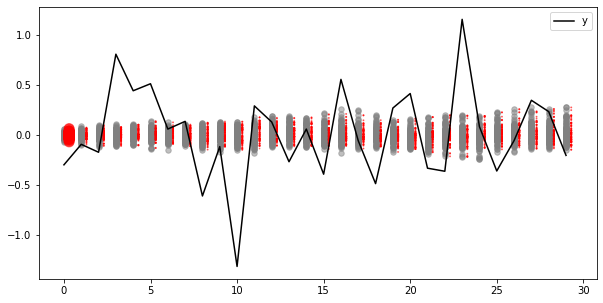

In [143]:
upto = 30
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_values[:upto], label='y', color='k')
for t in range(upto):
    ax.scatter(np.repeat(t, N), x_before[t, :], color='grey',s=30, alpha=0.5)
    ax.scatter(np.repeat(t+0.3, N), x_after[t, :], color='red', s=weights[t, :]*100, alpha=0.5)
plt.legend()
plt.show()

In [117]:
np.repeat(3, 10)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])